# Bimodal experiments

<h1>Bimodal Experiments</h1>

<p>
<b>Quantitative Big Imaging - ETHZ: 227-0966-00L</b>
<br />
    
<div class='row'>
    <div class='column23'>
        <p style="font-size:1em;">May 8, 2025</p>
        <br /><br />
        <p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
        <p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>
    </div>
    <div class='column13'>
        <img src="../../docs/figures/np_combine_156599_000000.svg" style="height:300px" />
    </div>
</div> 
</p>


In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
import skimage.io as io
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
import pandas as pd

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('default')
sns.set_style("whitegrid", {'axes.grid': False})

## Literature / Useful References

### Books
#### General:
- John C. Russ, "[The Image Processing Handbook](http://dx.doi.org/10.1201/9780203881095)",(Boca Raton, CRC Press) 
 
#### Fusion specific:
- Mitchell, H.B., ["Data Fusion: Concepts and Ideas"](https://www.doi.org/10.1007/978-3-642-27222-6), Springer Verlag, 2012.
- Mitchel, H.B., ["Image Fusion - Theories, Techniques and Applications"](https://www.doi.org/10.1007/978-3-642-11216-4), Springer Verlag, 2010.
- T. Stathaki, ["Image fusion"](https://doi.org/10.1016/B978-0-12-372529-5.X0001-7), Academic Press, 2008
- Goshtasby, A. Ardeshir, ["Image Registration Principles, Tools and Methods"](10.1007/978-1-4471-2458-0), Springer Verlag, 2012
- *Xiao, G., Bavirisetti, D.P., Liu, G., Zhang, X., ["Image Fusion"](https://www.doi.org/10.1007/978-981-15-4867-3), Springer Verlag

#### Software engineering
- Okken, B., [Python testing with pytest](https://pragprog.com/titles/bopytest2/python-testing-with-pytest-second-edition/)
- Wuttke, J. et al.[Guidelines for collaborative software development](http://dx.doi.org/10.3233/JNR-220002), 2022.
    

## Previously on QBI ...

<br/>
<center>
<img src='figures/10-all_icons-multimodality.svg' style="height:300px" />
</center>


- Image Enhancement 
    - Highlighting the contrast of interest in images
    - Minimizing Noise
- Automatic segmentation methods
- Component Labeling
- Single Shape Analysis
- Complicated Shapes
- Dynamic Experiments
- Image registration
- Statistics

## Outline

- Motivation (Why and How?)
- Scientific Goals
- Image fusion
- Bivariate segmentation
- Software engineering for repeatability

# Imaging modalities
## Some imaging experiments and their challenges

<table>
<col width="400px" />
<tr><th>Hydrology in soil and geology</th><th>Cultural heritage</th></tr>
<tr>
<td>
<center>
<img src="figures/soil.png" style="height:200px" />
</center>        
    
- Segmentation accuracy
- Estimate water content

</td>
<td>
<center>
<img src="figures/buddha_neutron.png" style="height:200px" />
</center>
    
- Segmentation accuracy
- Material classification
        
</td>  
</tr>
<tr><th>Building materials</th><th>Materials science</th></tr>
<tr>
<td>
<center>    
<img src="figures/CapillaryRise.png" style="height:200px" />
</center>        
    
- Estimate water content
- Dimensional changes

</td>
<td>
<center>    
<img src="figures/weld.png" style="height:200px" />
</center>
    
- Penetration power
- Ambiguous readings
        
</td>  
</tr>
</table>


```{figure} figures/soil.png
---
scale: 50%
---
In the soil the graylevels are often ambiguous.
```

```{figure} figures/buddha_neutron.png
---
scale: 50%
---
Studies of the cultural heritage.
```

```{figure} figures/CapillaryRise.png
---
scale: 50%
---
Dimensional changes in porous media.
```

```{figure} figures/weld.png
---
scale: 50%
---
Material science with material mixes.
```

## Reasons to select an imaging modality?
Reasons to select or reject a specific imaging method
<table>
    <cols width="600px">
<tr>
<th>
    <center>
    <img src="figures/noun_advantage.svg" style="height:100px">
            </center>
</th>    
<th>
         <center><img src="figures/noun_Disadvantage.svg" style="height:100px"></center>
</th></tr>
<tr><td>
    
- Good transmission
- Good contrast
- Relevant features visible
- Materials can be identified
    
</td><td>
    
- Low transmission
- Low contrast
- Not all features visible
- Ambiguous response
    
</td></tr>
</table>

    
Until now, we only collected image features from a single modality.

## The players of an imaging experiment

<br/>
<center>
<img src="figures/imaging_balls.png" style="height:700px" />
</center>

An imaging experiment involves several components that have to be tuned in order to obtain reliable results. The application comes in the first place for the experimentalist. It has been identified that spatial information is needed to answer a question and support a hypothesis. The choice of imaging modality depends on the material composition for two reasons.
1. Does the emitted signal provide relevant responses from the samples?
2. Does the sample "survive" the irradiation?

Therefore, it is important to understand the physics of the chosen modality. The next step is to select an acquisition techniques that provoides images in reasonable time, i.e. if the exposure times matches the time constants of the observed sample and available experiment time. Also, are the spatial resolution and field of view sufficient to represent object features in the images. 

The final step of an imaging experiment is the processing and analysis which can be more or less complicated as we have seen in the previous lectures. The processing workflow has some parts in common between different modalities, while other parts are very modality specific. 

```{figure} figures/imaging_balls.png
---
scale: 30%
---
An imaging experiment is only successful when all aspects are considered.
```

In many cases, a single modality is sufficent to answer the questions posed in the experiment. There are however cases some aspects are weakly represented in the images. This would in a first step indicate that there is a better modality for the task. When this modality on the other hand has different weaknesses that makes it suboptimal too, we to decide how to proceed;
1. Select the fittest modality and deal with its weaknesses and handle the difficulties ocurring in the analysis.
2. Use images from both modalities at the cost of additional experiment complexity and higher dimensional data analysis with the complication this brings.


## The aim of multimodal imaging
### Purpose of multi-modality
Match the advantages of each method against the disadvantages of the other methods to obtain more information than using each method individually.

<div class="row">
<div class="column23">

1. Extend range of operation.
2. Extend spatial and temporal coverage.
3. Reduce uncertainty.
4. Increase reliability.

</div>
<div class="column13">    
<img src="figures/multispectral_goggles.png" style="height:400px" />
</div>
</div>

```{figure} figures/multispectral_goggles.png
---
---
The multispectral glasses from the movie 'National Treasure'.
```

## Some considered modalities for materials science

In material science it often relevant to combine imagning with neutrons and X-rays. The reason is the complementarity between the two modalities. Simply put, neutrons are often sensitive to low-z materials while x-rays are more sensitive to high-z materials. Combining the two modalities is of particular interest when the sample is a mix of high and low-z materials.
```{figure} figures/camera_neutrons.png
---
scale: 20%
---
Neutron radiography of a camera.
```
```{figure} figures/periodicN.png
---
scale: 70%
---
Attenuation coefficients for thermal neutrons.
```
```{figure} figures/camera_xrays.png
---
scale: 10%
---
X-ray radiography of a camera.
```
```{figure} figures/periodicX.png
---
scale: 70%
---
Attenuation coefficients for 125keV X-rays.
```

<table>
<cols width="700px" />
<tr><th>Neutrons</th><th>X-rays</th></tr>
<tr>
<td>
<center>
<img src="figures/camera_neutrons.png" style="height:200px" />
</center>        
<center>
<img src="figures/periodicN.png" style="height:400px" />
</center>     
</td>
<td>
<center>
<img src="figures/camera_xrays.png" style="height:200px" />
</center>
    <center>
<img src="figures/periodicX.png" style="height:400px" />
</center>
</td>
</tr>
</table>

## Some considered modalities - Grating interferometry

Grating interferometry is an imaging technique that exploits the wave property of the beam. This makes it possible to extract more information than the traditional transmission image. These are
- The phase contrast - measures the phase shift of the beam to provide better contrast than the tranmission in some cases.
- The dark field contrast - is related to the scattered bream and can probe clusters of sample features that a much smaller than the resolution of the imaging system.

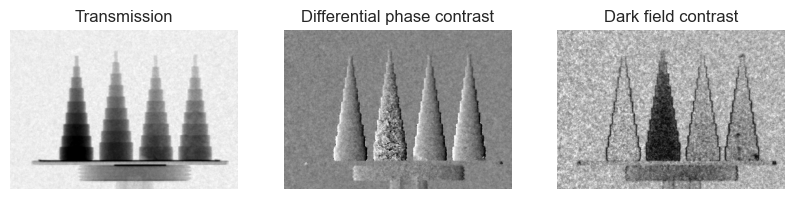

In [3]:
fig,ax=plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(io.imread("figures/nGI_TI.png"));  ax[0].set_title('Transmission');                ax[0].axis('off')
ax[1].imshow(io.imread("figures/nGI_DPC.png")); ax[1].set_title('Differential phase contrast'); ax[1].axis('off')
ax[2].imshow(io.imread("figures/nGI_DFI.png")); ax[2].set_title('Dark field contrast');         ax[2].axis('off');


- Data comparable on pixel level
- Non-linear relation between the variables.
- Improved estimation schemes using iterative process
- Physical interpretation/motivation to fuse?

## Some considered modalities - Spectroscopic imaging

<br/>
<center>
<img src="figures/ES_Fe.png" style="height:500px" />
</center>

```{figure} figures/ES_Fe.png
---
scale: 80%
---
Neutron energy scan through a piece of iron.
```

- Material analysis
- Selector calibration

S. Peetermans

## Some considered modalities for medical imaging

Imaging is widely used in medical applications. There are also many different imaging modalities available, each revealing it own particular information.

The modalities also differ in the resolution that can be achived. Therefore, it makes sense to combine the modalities to increase the understanding of provided information.

```{figure} figures/MedicalFusion.jpg
---
scale: 80%
---
Combining different medical imaging modalities.
```

<img src="figures/MedicalFusion.jpg" width="700px" />

[Du et al. 2015](https://doi.org/10.1016/j.neucom.2015.07.160)

## Condsidered modalities in biology and microscropy
            
- Fluorescence microscopy
<img src="figures/fluormicro.png" style="height:175px" />
    
- Electron microscopy
<img src="figures/electronmicro.png" style="height:175px" />
    
- NanoSIMS (Nanoscale Secondary Ion Mass Spectrometry)
<img src="figures/nanoSIMS.png" style="height:175px" />

[Loussert-Fonta et al. 2020](https://doi.org/10.1038/s42003-020-1095-x)


```{figure} figures/BiologyModalities.png
---
scale: 80%
---
The cryo section (ca. 100 nm thick) was imaged after simultaneous immunolocalization of carbonic anhydrase with anti-Alexa-associated secondary antibodies (a and b) and $\beta$-tubulin observed in TEM by 10 nm gold particles associated to the secondary antibody (c and d). The fluorescence microscope images (a and b; zoom in a) and the TEM micrographs (c and d; zoom in c) exhibit identical areas of the same thin section. e and f are NanoSIMS images showing the $^{13}$C and $^{15}$N distributions in the interior of a dinoflagellate symbiont. The area imaged is indicated by a red square in c. Scale bars: a and c: 5 $\mu{}$m; b and d: 500 nm; e and f: 2 $\mu{}$m.
```

## Other modalities and dimensionality

__The information can also be provided as few localized points__
- Single point measurements
- Surface information
- Single radiographs vs CT data

__to provide__
- Temperature
- Flowrate
- Pressure


# Data and image fusion

## Definition
The theory, techniques and tools which are used for 
- combining sensor data, or data derived from sensory data, 
- into a common representational format.
	
## Aim
> To improve the quality of the information, so that it is, in some sense, better than would be possible if the data sources were used individually.


[Mitchell 2012](https://www.doi.org/10.1007/978-3-642-27222-6)

    
## Fusion approaches - no golden recipe

You know by now that there is no guaranteed recipe in image analysis. The choice of methods leading to the quantitative information must be tailored to the type of images and what information you need to extract. The same applies to image fusion. There are as always some general concepts to rest upon, but afterwards you need to get creative.

### Fusion strategies

The purpose of the additional modality helps you to select the fusion strategy. 

- __Multivariate fusion:__ All data are combined using the same concept.
- __Augmented fusion:__ Modalities have different functions in the fusion process.
- __Artifact reduction by fusion:__ The second modality can be used to fill in the blanks or identify artifacts.
- __Combination:__ A single fusion method may not give the final result - combination 

### Select strategy
The fusion strategy determined by:

- Experiment objectives 
- Sample composition 
- Condition of the data

## Levels of fusion

|Input|Output|Description|
|:---:|:----:|:---|
|Data|Data|Input data is smoothed/filtered/segmented|
|Data|Feature|The pixels are reduced to features using multiple sources.|
|Feature|Feature|Input features are reduced in number, <br /> or new features are generated by fusing input features.|
|Feature|Decision|Input features are fused together to give output decision.|
|Decision|Decision|Multiple input decisions are fused together <br/>to give a final output decision. e.g. Random forest|


# Image fusion workflow

Image fusion is the process to combine images from different modalities with the aim to enhance the information compared the images individually. This process has serveral steps and the fusion can be done on several levels of abstraction.

```{figure} figures/imagefusion_process.pdf
---
scale: 100%
---
Flow chart showing how image fusion can be done
```

<br/>
<center>
<img src="figures/imagefusion_process.svg" style="height:800px" />
</center>
    
[Mitchel, 2010](https://www.doi.org/10.1007/978-3-642-11216-4), 
[Goshtasby, 2012](https://www.doi.org/10.1007/978-1-4471-2458-0)

## Catastrophic fusion
### Definition
The combination perform worse than the individual modalities... don't fuse because you can!





<div class="row">
<div class="column23">
    
Catastrofic fusion can be caused by:
- Selection of the wrong variables.
- Too complex combination.
- Sensor information canceling each other.

</div>
<div class="column13">    

<img src="figures/bad_soup.png" style="height:400px" />
</div>
</div>

```{figure} figures/bad_soup.png
---
scale: 50%
---
More chefs don't always mean better soup, the same applies to data fusion. Chose your source combination and fusion metods carefully.
```

## Image registration
From last weeks lecture: A series of affine transformations to bring images on the same grid.

We saw last week that image registration can be a quite complicated matter that involves the choice of optimizer, transform types, and cost function. Then we only considered images of the same modality. The introduction of a new modality adds to the complexity:
- The images show different features due their contrast mechanisms
- Different image sharpness.
- Different scales.
- Distortion

This leads to different choices of cost functions and maybe even changing the optimizer.

### The process

<img src="figures/registration.svg" style="height:700px" />

```{figure} figures/registration.pdf
---
name: fig_nxregistration
scale: 100%
---
Registration optimizes the scale, rotation, and position of an image compared to a fixed reference. 
```

The registration process still remains the same in the greater context. You have a fixed image and a moving image. The example in {numref}`Figure {number} <fig_nxregistration>` show an example how an X-ray image is registered to a neutron image.

## Registration considerations
Registration is an optimization problem with many local minima.

### Manual or guided registration
- Perform the full transformation manually
- Identify land marks, points, lines, planes
- Provide a coarse preregistration

### Automatic registration 
- Iterative process 
- Metrics
- Multi-modality loose common landmarks 

[Goshtasby, 2012](https://www.doi.org/10.1007/978-1-4471-2458-0)

## Cost functions for multimodal registration

When registering **multiple modalities** (e.g. neutron and X-ray images, or MRI and CT), the challenge is that **intensities are not directly comparable** across images.

> MSE is misleading when the images are from different modalities

We need contrast insensitive metrics:


1. Mutual Information (MI)


2. Cross-Correlation of Gradients

3. Modality Independent Neighborhood Descriptor (MIND)

4. Correlation Ratio

5. Feature-Based Costs


### Practical Tip

Use **mutual information** or **MIND** for dense, intensity-based registration, and fall back on **feature-based approaches** when the modalities are very dissimilar or noisy.

# Qualitative fusion: Registration and covisualization
Use interactive _e.g._ VG Studio or 3DSlicer to 

- Register data sets
- Interactive guided segmentation of the separate data sets.

```{figure} figures/swordN.png
---
scale: 100%
---
The sword from lake Zug as seen with neutrons.
```

```{figure} figures/swordX.png
---
scale: 100%
---
The sword from lake Zug as seen with X-rays.
```

<table>
<cols width="700px" />
<tr><th>Neutrons</th><th>X-rays</th></tr>
<tr>
<td>
<center>
<img src="figures/swordN.png" style="height:400px" />
</center>            
</td>
<td>
<center>
<img src="figures/swordX.png" style="height:400px" />
</center>
</td>
</tr>
</table>


[Mannes et al., 2015](https://doi.org/10.1016/j.phpro.2015.07.092)

## Demonstration of some visualization methods
### Let's load some test data

We will use images of a snail shell obtained using neutrons and X-rays. The X-ray image is, in this case, less sharp which is unusual. This probably relates to an unsuccessful geometry calibration.

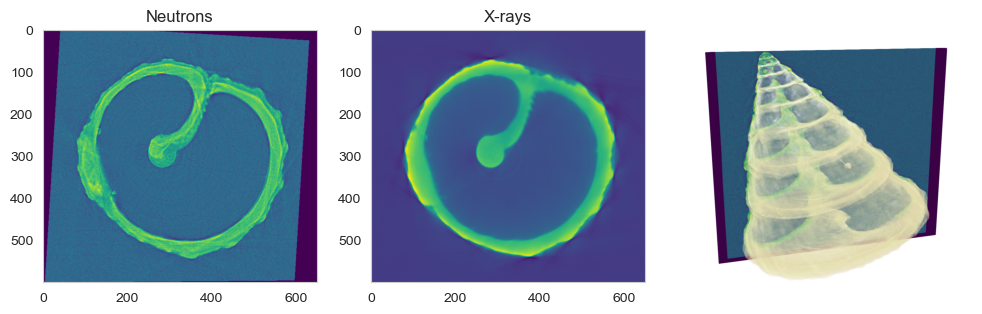

In [4]:
imgA=np.load('data/shellN.npy')
imgB=np.load('data/shellX.npy')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,5))
ax1.imshow(imgA,cmap='viridis'), ax1.set_title('Neutrons')
ax2.imshow(imgB,cmap='viridis'), ax2.set_title('X-rays');
ax3.imshow(plt.imread('figures/snailshellNeutron.png')); ax3.axis('off');

### Checker board visualization


It is, in many cases, relevant to visualize the resulting registration no matter how it was obtained. The checker board visualization shows the two modalities with alternating sub image blocks. This shows how well aligned the two modalites are but also the differences in contrast.

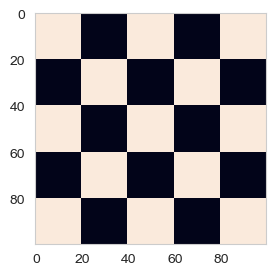

In [5]:
def checkerBoard(imgA,imgB,tiles=10) :
    if imgA.shape != imgB.shape :
        raise Exception('Image have different sizes')
    
    dims     = imgA.shape
    tileSize = (dims[0]//tiles,dims[1]//tiles)
    
    mix = np.zeros(dims)
    
    for r in np.arange(0,tiles) :
        for c in np.arange(0,tiles) : 
            if (c+r) % 2 : 
                mix[(r*tileSize[0]):((r+1)*tileSize[0]),(c*tileSize[1]):((c+1)*tileSize[1])]= imgB[(r*tileSize[0]):((r+1)*tileSize[0]),(c*tileSize[1]):((c+1)*tileSize[1])]
            else : 
                mix[(r*tileSize[0]):((r+1)*tileSize[0]),(c*tileSize[1]):((c+1)*tileSize[1])]= imgA[(r*tileSize[0]):((r+1)*tileSize[0]),(c*tileSize[1]):((c+1)*tileSize[1])]

    return mix
plt.figure(figsize=(3,3))
plt.imshow(checkerBoard(np.ones((100,100)),np.zeros((100,100)),tiles=5),interpolation='none');

#### Try checker board with images

In this example, we show the same sample using neutron and X-ray images. This was done without any bias or contrast adjustment. We could have aimed for having the void outside the snail shell on the same level and thus get less checkered appearence.

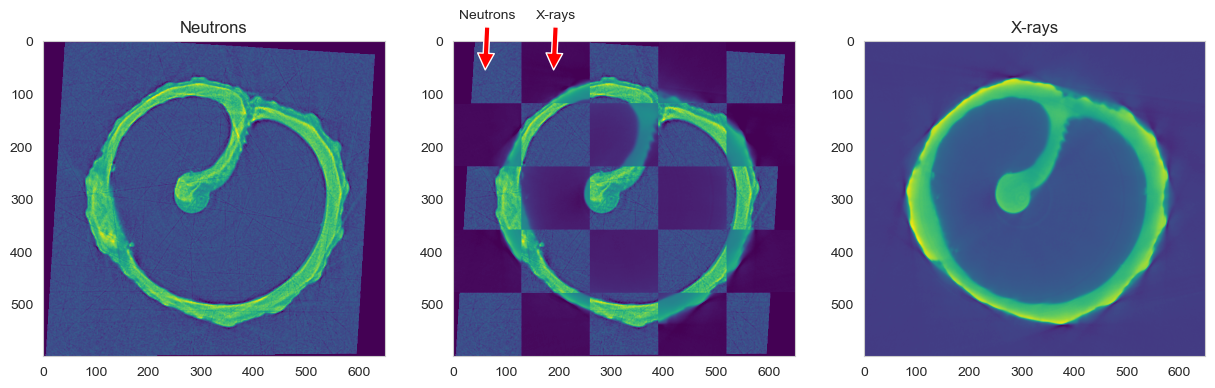

In [6]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
ax1.imshow(imgA,cmap='viridis',vmin=10000,vmax=60000), ax1.set_title('Neutrons')
ax2.imshow(checkerBoard(imgA,imgB,tiles=5),cmap='viridis',vmin=10000,vmax=60000); 
ax2.annotate('Neutrons',
            xy=(60, 60), xycoords='data',
            xytext=(0.1, 1.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')
ax2.annotate('X-rays',
            xy=(190, 60), xycoords='data',
            xytext=(0.3, 1.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')
ax3.imshow(imgB,cmap='viridis'), ax3.set_title('X-rays');

### Color channel mixing

Another covisualization method is to use color coding. The images from the single modalities are mostly only descrbing a scalar value like intensity, attenuation coefficients etc. We saw in the first lecture that this scalar value can be mapped to a color map and thus show colorful images that may be easier to interpret than a gray scale.

Color images like pictures and cartoons use different models to represent colors as they appear in the real world. These models use multiple chanels to represent the color. Some examples are RGB _red, green, and blue_ and HSV _hue, saturation, and value_.

We can (mis-)use these color triplets to co-visualize the information from our modalities.

With two or three modalities, we can visualize the mix using the RGB color channels:

$$\begin{cases}
R & modality_A\\
G & modality_B\\
B & \frac{modality_A+modality_B}{2}
\end{cases}$$

some intensity normalization and scaling may be needed for best result.

#### Implementation of channel mixing

The function below implements the co-visualization of two modalities. It does a min-max normalization, this could also have been a whitening normalization 
$$norm(img)=\frac{img-E[img]}{s[img]}$$

The order argument tells which color chanel each piece of information should use.

In [7]:
def channelMix(imgA,imgB, order=(0,1,2)) :
    imgAN=(imgA-imgA.min())/(imgA.max()-imgA.min())
    imgBN=(imgB-imgB.min())/(imgB.max()-imgB.min())
    
    rgb=np.zeros((imgA.shape[0],imgA.shape[1],3));
    rgb[:,:,order[0]]=imgAN
    rgb[:,:,order[1]]=imgBN
    rgb[:,:,order[2]]=0.5*(imgAN+imgBN)
    
    return rgb

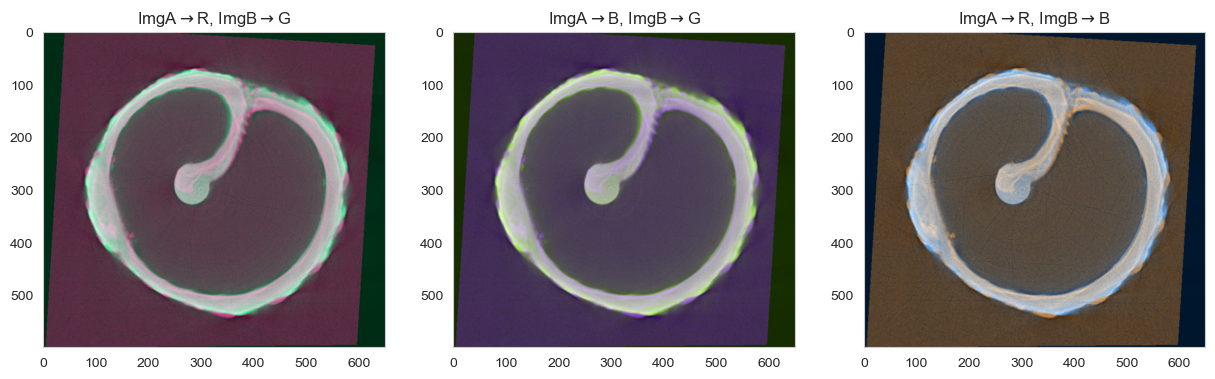

In [8]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,6))
ax1.imshow(channelMix(imgA,imgB,order=(0,1,2))), ax1.set_title(r'ImgA$\rightarrow$R, ImgB$\rightarrow$G');
ax2.imshow(channelMix(imgA,imgB,order=(2,1,0))), ax2.set_title(r'ImgA$\rightarrow$B, ImgB$\rightarrow$G');
ax3.imshow(channelMix(imgA,imgB,order=(0,2,1))), ax3.set_title(r'ImgA$\rightarrow$R, ImgB$\rightarrow$B');

The choice of which color permutation you use depends on how well the two modalities appear and also on the application field. The permuation to the right in the figure is for example well suited for visualizing water in soil assuming the blue channel modality is more sensitive to water.

# Bimodal segmentation

## Histogram of single modality

When you do experiments with a single modiality, you only obtain a single histogram. The modes of the histogram may merge into a single mode if the SNR is too low to separate the feature classes. This leads to a large amount of miss-classifications. The blue region between the histogram peaks in {numref}`Figure {number} <fig_singlehistA>` represents the area of ambiguous decisions. 

```{figure} figures/overlapping_classesA.png
---
scale: 30%
name: fig_singlehistA
---
Histogram of two classes using modality _A_.
```

<img src="figures/overlapping_classesA.png" style="height:500px">

## Individual histograms of two modalities

Now we may conclude that the first modality we looked at doesn't provide sufficient information to make a reliable segmentation. Therefore, we go to a second modality. Unfortunately, this modality has the same low class separability as you can see in {numref}`Figure {number} <fig_singlehistB>`. This time the two classes have different responses and the histogram modes have swapped compared to {numref}`Figure {number} <fig_singlehistA>`. 
```{figure} figures/overlapping_classesB.png
---
scale: 30%
name: fig_singlehistB
---
Histogram of two classes using modality _B_.
```
So the conclusion is that we don't get much closer to our segmented image using these modalities individually.

<table>
<cols width="700px" />
<tr><th>Modality A</th><th>Modality B</th></tr>
<tr>
<td>
<center>
<img src="figures/overlapping_classesA.png" style="height:500px" />
</center>            
</td>
<td>
<center>
<img src="figures/overlapping_classesB.png" style="height:500px" />
</center>
</td>
</tr>
</table>

## Bivariate histogram

Now, if we start combining the two modalities, we start seeing the benefit of using more than one modality. The bivariate histogram, which we already have looked at in previous lectures is a great way to visualize how two variables depend on each other. 

```{figure} figures/bivariate_classes.png
---
scale: 40%
name: fig_bivariatehist
---
A bivariate histogram of modalities _A_ and _B_.
```

In the histogram show in {numref}`Figure {number} <fig_bivariatehist>`, we see that there is a clear separation between class _A_ and _B_ that could be easily thresholded.

<img src="figures/bivariate_classes.png" style="height:600px" />

### Example: Roots in soil

```{figure} figures/root_slices.pdf
---
scale: 80%
name: fig_rootimages
---
Tomography slices of a soil sample with roots.
```

<img src="figures/root_slices.svg" style="height:500px"/>

[Kaestner et al., 2016](https://doi.org/10.1016/j.phpro.2017.06.043)

### Bivariate histogram of roots

```{figure} figures/root_histogram.png
---
scale: 80%
name: fig_rootimageshist
---
Bivariate histogram of the root images in {numref}`Figure {number} <fig_rootimages>`
```

<img src="figures/root_histogram.png" style="height:700px" />

## Segmentation methods
### Data
- Images from $M$ modalities $f_1, \ldots, f_M$
- Registered
- Artifact corrected

### Classes
The $N$ classes are described by: 
$$\begin{cases}
\mathcal{H}_1 : p(\mathbf{\mu}_1,\Sigma_1)\nonumber\\
\mathcal{H}_2 : p(\mathbf{\mu}_2,\Sigma_2)\nonumber\\
\vdots\nonumber\\
\mathcal{H}_N : p(\mathbf{\mu}_N,\Sigma_N)\nonumber
\end{cases}
$$


[Duda, Hart, and Stork, 2001](https://www.wiley.com/en-us/Pattern+Classification%2C+2nd+Edition-p-9781118586006)

## Previous segmentation methods

In this class we have already looked into many different ways to perform the segmentation on images. These are methods that are well suited for segmenting bi- or multivariate data:

- k-means
- k-NN
- Regression
- Neural networks

## Gaussian mixture model

With Gaussian distribution we can describe the bivariate histogram using:
$$p(\theta)=\sum_{1}^{N} \phi_i\,\mathcal{N}(\mathbf{\mu}_i,\Sigma_i) $$

- $\mu{}_i$ - vector with averages for each class.
- $\Sigma{}_i$ - covariance matrix for each class.
- $\phi{}_i$ - mixing coefficient.

In [9]:
# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C1 = np.array([[1, -0.5], [-0.5, 1]])
C2 = np.array([[1, 0.25], [0.25, 1]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C1), np.dot(np.random.randn(n_samples, 2),C2) + np.array([-3, 3])]

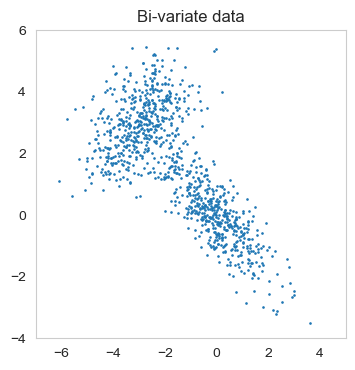

In [10]:
plt.figure(figsize=[4,4])
plt.scatter(X[:,0],X[:,1],0.8)
plt.xlim(-7., 5.),plt.ylim(-4., 6.)
plt.title('Bi-variate data');

In [11]:
def plot_results(X, Y_, means, covariances, title, ax, showShape=True, showCenter=False):
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1],2, color=color,alpha=0.2)

        # Plot an ellipse to show the Gaussian component
        if showShape :
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.3)
            ax.add_artist(ell)
            
        if showCenter :
            ax.plot(mean[0],mean[1],'ro')

    ax.set_xlim(-7., 5.)
    ax.set_ylim(-4., 6.)
    ax.set_title(title)


### Gaussian mixture model fitting

In this example we explore how the Gaussian mixture model handles an increasing number of classes. The data set is created with two classes, but what happens when we increase the number of classes.

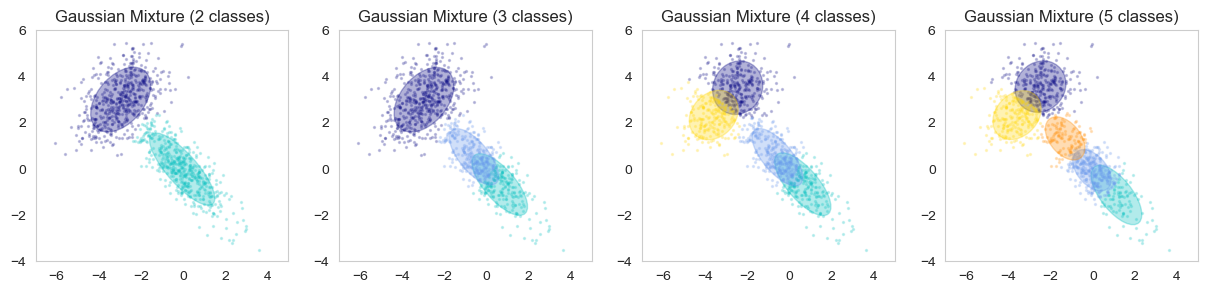

In [12]:
fig, axes = plt.subplots(1,4,figsize=(15,3))
# Fit a Gaussian mixture with EM using five components
for i,ax in zip(np.arange(0,len(axes.ravel())),axes.ravel()) :
    classes = i+2
    
    gmm = mixture.GaussianMixture(n_components=classes,random_state=0, covariance_type='full').fit(X)

    plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             title='Gaussian Mixture ({} classes)'.format(classes), ax=ax)


The two classes are, as expect, well identified in the two-class model. Models with more classes split the original classes into smaller classes, but the new classes cluster in the regions of the original two classes.

## Classification distances 
For a set of multivariate normal distributions $p_i=\mathcal{N}(\mu_i,\Sigma_i)$

We can find the nearest neighbor class using the following distances
### Euclidean
Distance between two points
$$D_{E}=\sqrt{(x-\mu_1)^T \cdot (x-\mu_1)} $$

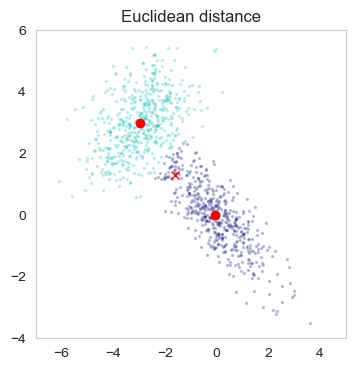

In [13]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
m=[-1.6,1.3]
fig,ax1=plt.subplots(1,figsize=(4,4))

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             'Euclidean distance',ax1, showShape=False,showCenter=True)
ax1.plot(-1.6,1.3,'rx');

The Euclidean distance is the least complicated distance metric between two classes. It only requires the centroid, i.e. the mean, of the two classes. This does of course have the disadvantage that it is not sentitive to the distribution shape.

### Mahanalubis
Distance from class $i$ to point $x$
$$D_M=\sqrt{\left(x-\mu_i\right)^T \Sigma_i \left(x-\mu_i\right)}$$

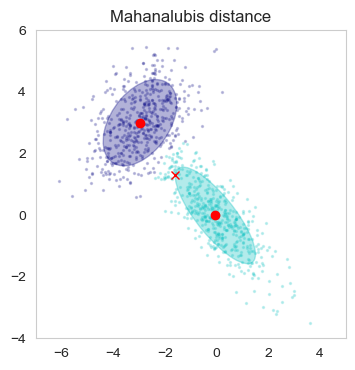

In [14]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
m=[-1.6,1.3]
fig,ax2=plt.subplots(1,figsize=(4,4))

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             'Mahanalubis distance'.format(2),ax2, showCenter=True)
ax2.plot(-1.6,1.3,'rx');

The Mahanalubis distance adds the covariance of the distribution in the calculation. This adds the orientation and shape of the distribution which makes it easier to handle ambiguous cases that were hard to catch with the Euclidean distance.

### Bhattacharia
Distance between two classes 
$$D_B=\frac{1}{8}\left(\mu_1-\mu_2\right)^T \Sigma \left(\mu_1-\mu_2\right) + \frac{1}{2}\ln\left(\frac{|\Sigma|}{\sqrt{|\Sigma_1|\cdot|\Sigma_2|}}\right)\qquad \Sigma=\frac{\Sigma_1+\Sigma_2}{2}$$


Assign the point to the class with shortest distance.

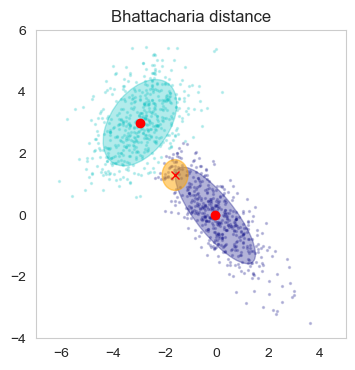

In [15]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
m=[-1.6,1.3]
fig,ax3=plt.subplots(1,figsize=(4,4))

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             'Bhattacharia distance'.format(2),ax3, showCenter=True)
v=1
ell = mpl.patches.Ellipse(m, v, v, angle=0, color='orange')
ell.set_clip_box(ax3.bbox)
ell.set_alpha(0.5)
ax3.add_artist(ell)
ax3.plot(m[0],m[1],'rx');

The Bhattacharia distance add even further complexity to the distance computation as it als require the covariance matrix of the probed point. Obtaining the sample covariance is expensive in terms of resolution because it requires a neighborhood to be computed.

## Graphical presentation of the different distances

Here is a side by side comparison of the three distance metrics.

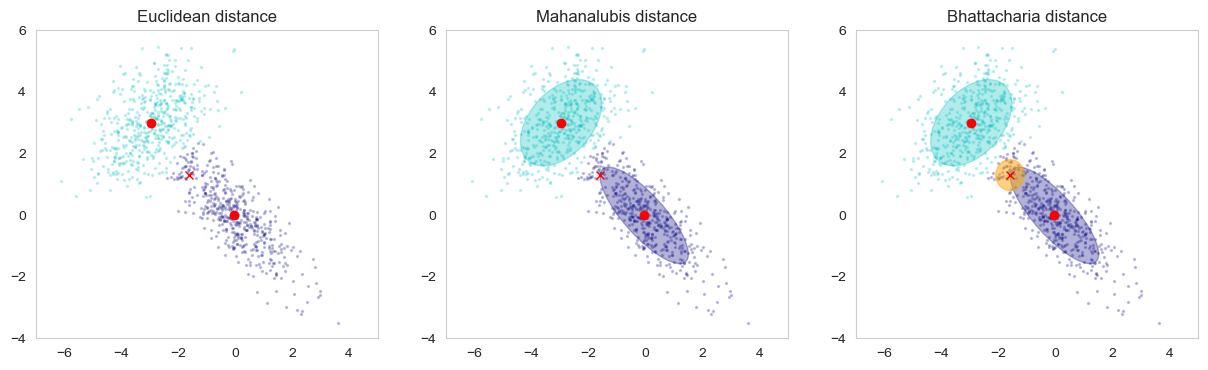

In [16]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
m=[-1.6,1.3]
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             'Euclidean distance',ax1, showShape=False,showCenter=True)
ax1.plot(-1.6,1.3,'rx')
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             'Mahanalubis distance'.format(2),ax2, showCenter=True)
ax2.plot(-1.6,1.3,'rx')

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,
             'Bhattacharia distance'.format(2),ax3, showCenter=True)
v=1
ell = mpl.patches.Ellipse(m, v, v, angle=0, color='orange')
ell.set_clip_box(ax3.bbox)
ell.set_alpha(0.5)
ax3.add_artist(ell)
ax3.plot(m[0],m[1],'rx');

## Segmentation by Euclidean distance

```{figure} figures/roots_segmentation.pdf
---
name: fig_euclideansegmentation
scale: 80%
---
Segmenting the root image in 
```


<img src="figures/roots_segmentation.svg" style="height:500px" />

[Kaestner et al., 2016](https://doi.org/10.1016/j.phpro.2017.06.043)

# Bivariate estimation: Working with attenuation coefficients

## Beer-Lamberts law

$$ I=I_0\,e^{-\frac{\rho}{A}\,N_A\,\sigma\,x} $$
- $\rho$ Material denstity
- $A$ Atomic weight
- $\sigma$ microscopic cross section
     - Probability of interaction
     - modality dependent

- $x$ propagation length

## Equation system

$$\begin{split}\Sigma{}_{0}\,x_{0} + \Sigma{}_{1}\,x_{1}&=q_{N}+ noise\nonumber\\ \mu{}_{0}\,x_{0} + \mu{}_{1}\,x_{1} &=q_{X}+ noise\end{split}$$
- attn coeff known $\rightarrow$ estimate lengths.
- More pixels $\rightarrow$ use least squares estimate.



# Multi modal experiments
Many bimodal experiments are done separately.

There many reasons for this, two are:

- Limited resources
- Scanners at different locations

This is often the case in medical imaging where the hospitals have different dedicated machines for each modality. It is also not always that the patient is scan using all relevant modalities at the same time, but different modalities are used at different stages of the therapy.

This is also a common approach in materials science and ex situ imaging. The home laboratory may own their own X-ray CT scanner but they need to got to a large scale facility to obtain more information with further modalities.

Next steps:
- Dynamic experiments

Last week we looked into the topic of dynamic experiments. The use of bimodal imaging is also very relevant in dynamic experiments. The observed samples and processes often change shape when you introduce a liquid, apply a preasure, etc. These shape changes are often more visible in one modality than the other. Ideally, you will have a system where one modality is sensitive to dimensional changes while the other is sensity the changes in mixing ratios and other process related parameters. 

- Combined setups

<img src="figures/NX-OnTheFlySetup.svg" style="height:400px" />


Combined setups all simultaneous acquisition using two modalities. This has the advantage that you can perform dynamic
experiments. 

{numref}`Figure {number} <fig_bivariatehist>` show a setup for bimodal neutron and X-ray imaging. The system has two difference beam geometries neutrons uses parallel beam and X-rays a cone beam. The beams are also at oblique angles and mostly also resulting in different resolutions, there it is a first requirement that the resulting iamges are registered before any analysis can be performed. 

```{figure} figures/NX-OnTheFlySetup.pdf
---
---
The outline of a bimodal imaging system for neutrons and X-rays. 
```

## Summary of multimodal experiments

In multimodal experiments 
- We try to use the advantages of more than one modality
- More data is produced
- The analysis must be adapted
    - Registration
    - Fusion
    - Segmentation

# Some software engineering
Repeatable workflows require some software engineering skills


## Repeatable workflows
From lecture 8

<img src="figures/diciplined_steps.svg" width=800 />

Repeatability requires that your code:
- is testable
- has a tracked history
- is reviewed
- is documented

... and keep track of bugs and new ideas in an issue manager.


```{figure} figures/diciplined_steps.pdf
---
scale: 80%
---
The outline of a bimodal imaging system for neutrons and X-rays. 
```

### Tools to support reproducible workflows
<br/>
<div class="row">
<div class="column13">
<img src="figures/np_node.svg" width="150px" />  
    
__Use a repository__
    
History management

</div>
<div class="column13">
<img src="figures/np_test.svg" width="150px" />
    
__Use automated tests__
    
Guarantees unit functionality

</div>
<div class="column13">
<img src="figures/np_continuous-deployment.svg" width="150px" />
    
__Use a build server__
    
Combines repository and tests
    

</div>
</div>

Each of these measures will be described in more detail in the following sections, but first a little introduction to what each step brings.

#### Repositories
Correctly used a source code repository helps you to keep track of your changes and also makes it possible to reproduce a result eventhough your code has evolved since you produced an earlier result. The repo also makes it possible to work on parallel ideas without ruining the main code. Hence, it gives you more freedom to be creative with less risk.

#### Automated tests
Automated tests are small programs written to verify that your main code actually does what it is supposed to do. This is a sanity check that is very helpful when you start working on different branches in your repository. The tests must always run successfully before you are allowed to merge a new piece of code into the main branch of your repository. 

#### Build server
A build server is set up to build and test the code you submit to the repository. This is particularly important when your project grows. For smaller projects it less relevant.

## How to organize the code

In this course, we have mainly implemented the analysis using python and in particular using jupyter notebooks. 

Notebooks are good for prototyping ... but are not good for
- structuring/maintenance 
- repositories
- portability/sharing
- testing

To achieve a cleaner workflow with your code it a good idea to separate common functions that are used often in many contexts onto library files. This has the advantage that the notebooks are cleaner and that a change in a function is propagated to all notebook using that function without having to copy the function between notebooks. Library files are also easier to access in testing frameworks.

Save functions in .py files which are imported

Your functions are saved in a file 'mylib.py'  
```python
import mylib

mylib.myfunction(1234)
```

Reload during development in a notebook
```python
import importlib
importlib.reload(mylib)
```

### Why reloading is used in notebooks:
In Jupyter, you might edit a module (say `mylib.py`). Reloading a library is essential here, otherwise the notebook doesn't know that you have updated you library functions. The reloading allows the notebook to **see changes without restarting the kernel**. Restarting is time consuming as you have to run the entire notebook again. 

Reloading modules is of course most important during the development phase. 

### Why it's not useful in scripts:
Reloading is naturally less relevant in end user notebooks or scripts.
* In a regular script:

  * The module is **imported once at runtime**.
  * The script **starts fresh each time**, so there's no need to "reload" — it loads from scratch every time anyway.
  
* Using `importlib.reload()` in a script is redundant unless you're dynamically loading modules in a very specialized case (e.g., plugin systems or hot-reload servers).

More advanced use of libraries is beyond the scope of this lecture, but it is well described in many books and online resources.

## Documentation

Documentation is a tedious task that many dread and leave to the end, if at all writing it with the motivation that "It's anyway only I who will use the code". This kind of reasoning is not very sustainable. Have you tried to take a look a your own code some months later? Did you instantaneously understand what it does and how is should be used?

There are different levels of documentation:

- In-code comments
- API (application programmer interface) describes which arguments and return values
- User documentation describes how the code is intended to be used.

API documentation is a minimum!

### API Documentation
#### Doc string in python

In [17]:
def fancy_function(value) :
    """ Description: Makes fantastic calculations

    Parameters:
    value (int): Description of argument

    Returns:
    int: Returning value

    """
    return 42+value

help(fancy_function)

Help on function fancy_function in module __main__:

fancy_function(value)
    Description: Makes fantastic calculations
    
    Parameters:
    value (int): Description of argument
    
    Returns:
    int: Returning value



#### Doxygen for many languages

https://www.doxygen.nl

## Unit Testing

In computer programming, unit testing is a method by which individual units of source code, sets of one or more computer program modules together with associated control data, usage procedures, and operating procedures, are tested to determine if they are fit for use.

- Intuitively, one can view a unit as the smallest testable part of an application
- Unit testing is possible with every language
- Most (Java, C++, Matlab, R, Python) have support for automated testing and reporting

- [Computational science: ... Error](http://doi.org/10.1038/467775a)
- [Unit testing guidelines](https://medium.com/@sachinsoni600517/unit-testing-in-python-a-comprehensive-guide-for-beginners-985eec71bb4d)

## Unit Testing - design
The first requirement for unit testing to work well is to have your code divided up into small independent parts (functions)
### What to test?
 - Each part can then be tested independently (unit testing)
     - If the tests are well done, units can be changed and tested independently
     - Makes upgrading or expanding tools _easy_
 - The entire path can be tested (integration testing)
     - Catches mistakes in integration or _glue_

### How to test
- The _happy path_ - check what it is supposed to do
- To __provoke__ your code - provide data that will fail execution

### Test data
Ideally with realistic but simulated test data

<div class="alert alert-success">
<center>The utility of the testing is only as good as the tests you make</center>
</div>

### A unit test example
Given the following function that counts all nonzero voxels in an image.
```python
def vxCnt=countVoxs(inImage)
```



We can write the following tests:

```python 
def testEmpty2d() :
    assert countVoxs(zeros(3,3)) == 0
```

```python
def testEmpty3d() :
    assert countVoxs(zeros(3,3,3)) == 0
```

```python 
def testDiag2d() :
    assert countVoxs(eye(3)) == 3
```

Unit tests can, as you see in this example, be quite trivial and that is the strength of the tests. They are fast to run and don't cost much waiting time and at the same time they also guarantee that the functionality is provided.

## Unit Testing: Example
Given the following function
```function shapeTable=shapeAnalysis(inImage)```

We should decompose the function into sub-components with single tasks:

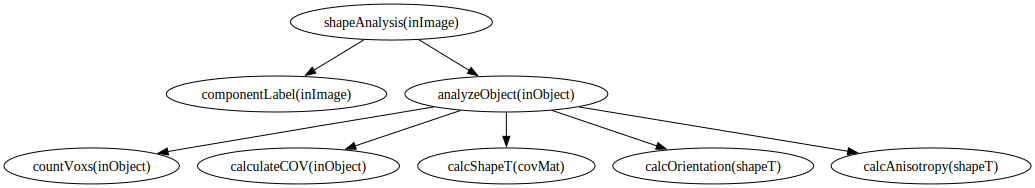

In [18]:
from graphviz import Digraph
dot = Digraph()
dot.edge('shapeAnalysis(inImage)', 'componentLabel(inImage)'), dot.edge('shapeAnalysis(inImage)', 'analyzeObject(inObject)')
dot.edge('analyzeObject(inObject)','countVoxs(inObject)'),     dot.edge('analyzeObject(inObject)','calculateCOV(inObject)')
dot.edge('analyzeObject(inObject)','calcShapeT(covMat)'),      dot.edge('analyzeObject(inObject)','calcOrientation(shapeT)')
dot.edge('analyzeObject(inObject)','calcAnisotropy(shapeT)')
dot

## Unit Testing in Python

### unittest
The built-in Python module, ideal for beginners due to its simplicity.

### PyTest
A popular framework known for its flexibility, advanced features, and readable style.
- well suited for larger projects 
- you make a set of specific tests for each module 
- run each time the project is updated. 

## Unit testing examples from Scikit Image
https://github.com/scikit-image/scikit-image/tree/master/skimage

- [Test Watershed](https://github.com/scikit-image/scikit-image/blob/16d3fd07e7d882d7f6b74e8dc4028ff946ac7e63/skimage/morphology/tests/test_watershed.py#L79)

- [Test Connected Components](https://github.com/scikit-image/scikit-image/blob/16d3fd07e7d882d7f6b74e8dc4028ff946ac7e63/skimage/morphology/tests/test_ccomp.py#L13)

```python
class TestWatershed(unittest.TestCase):
    eight = np.ones((3, 3), bool)

    def test_watershed01(self):
        "watershed 1"
        data = np.array([[0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0],
                               [0, 1, 1, 1, 1, 1, 0],
                               [0, 1, 0, 0, 0, 1, 0],
                               [0, 1, 0, 0, 0, 1, 0],
                               [0, 1, 0, 0, 0, 1, 0],
                               [0, 1, 1, 1, 1, 1, 0],
                               [0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0]], np.uint8)
        markers = np.array([[ -1, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0],
                                  [  0, 0, 0, 0, 0, 0, 0],
                                  [  0, 0, 0, 0, 0, 0, 0],
                                  [  0, 0, 0, 1, 0, 0, 0],
                                  [  0, 0, 0, 0, 0, 0, 0],
                                  [  0, 0, 0, 0, 0, 0, 0],
                                  [  0, 0, 0, 0, 0, 0, 0],
                                  [  0, 0, 0, 0, 0, 0, 0]],
                                 np.int8)
        out = watershed(data, markers, self.eight)
        expected = np.array([[-1, -1, -1, -1, -1, -1, -1],
                      [-1, -1, -1, -1, -1, -1, -1],
                      [-1, -1, -1, -1, -1, -1, -1],
                      [-1,  1,  1,  1,  1,  1, -1],
                      [-1,  1,  1,  1,  1,  1, -1],
                      [-1,  1,  1,  1,  1,  1, -1],
                      [-1,  1,  1,  1,  1,  1, -1],
                      [-1,  1,  1,  1,  1,  1, -1],
                      [-1, -1, -1, -1, -1, -1, -1],
                      [-1, -1, -1, -1, -1, -1, -1]])
        error = diff(expected, out)
        assert error < eps
```

## Unit testing in python - DocTests

Keep the tests in the [code itself](https://github.com/scikit-image/scikit-image/blob/16d3fd07e7d882d7f6b74e8dc4028ff946ac7e63/skimage/filters/thresholding.py#L886): 

```python
def apply_hysteresis_threshold(image, low, high):
    """Apply hysteresis thresholding to `image`.
    This algorithm finds regions where `image` is greater than `high`
    OR `image` is greater than `low` *and* that region is connected to
    a region greater than `high`.
    Parameters
    ----------
    image : array, shape (M,[ N, ..., P])
        Grayscale input image.
    low : float, or array of same shape as `image`
        Lower threshold.
    high : float, or array of same shape as `image`
        Higher threshold.
    Returns
    -------
    thresholded : array of bool, same shape as `image`
        Array in which `True` indicates the locations where `image`
        was above the hysteresis threshold.
    Examples
    --------
    >>> image = np.array([1, 2, 3, 2, 1, 2, 1, 3, 2])
    >>> apply_hysteresis_threshold(image, 1.5, 2.5).astype(int)
    array([0, 1, 1, 1, 0, 0, 0, 1, 1])
    References
    ----------
    .. [1] J. Canny. A computational approach to edge detection.
           IEEE Transactions on Pattern Analysis and Machine Intelligence.
           1986; vol. 8, pp.679-698.
           DOI: 10.1109/TPAMI.1986.4767851
    """
    low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
    mask_low = image > low
    mask_high = image > high
```

## Unit Testing with Jupyter
Working primarily in notebooks makes regular testing more difficult but not impossible. 
- If we employ a few simple tricks we can use doctesting seamlessly inside of Jupyter.  
- We can make what in python is called an annotatation to setup this code. 

First, we need a function to interpret the code in the doc string. This function will be used as decorator later in the example. 

In [19]:
import doctest
import copy
import functools

def autotest(func):
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=True, name=func.__name__)
    return func

The decorator is used like

```python
@autotest
def my_function(val) 
```

which is a different way to write

```python
autotest(my_function())
```

### A very simple test
This test will be used in a jupyter notebook.

It is implemented as a DocTest. The function is supposed to return five added to the input value. The test is implemented for the specific case with the input '5' and we expect the function to return 10.

In [20]:
@autotest
def add_5(x):
    """
    Function adds 5
    >>> add_5(5)
    10
    """
    return x+5

Finding tests in add_5
Trying:
    add_5(5)
Expecting:
    10
ok


The test returned 10 and DocTest concludes that the test passed with an 'ok'. This is a very simple function that already assumes you enter a number, but what would happen if we call the function with a string of a complicated object of some kind? The function should be extended with checks if the correct data type is provided, which in turn would require further tests to verify that the functionality under these conditions. 

### Testing an image processing algorithm

Numerical algorithms are often hard to check with unit tests. In particular, when noise is added. You can however always test the basic functionality. Below we have an example that tests wether the label function does what it is supposed to do:
1. A single object -  labels 0 and 1
2. Break the object in two - labels 0-2

In [21]:
from skimage.measure import label
import numpy as np
@autotest
def simple_label(x):
    """
    Label an image
    >>> test_img = np.eye(3)
    >>> test_img
    array([[1., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]])
    >>> simple_label(test_img)
    array([[1, 0, 0],
           [0, 1, 0],
           [0, 0, 1]])
    >>> test_img[1,1] = 0
    >>> simple_label(test_img)
    array([[1, 0, 0],
           [0, 0, 0],
           [0, 0, 2]])
    """
    return label(x)

Finding tests in simple_label
Trying:
    test_img = np.eye(3)
Expecting nothing
ok
Trying:
    test_img
Expecting:
    array([[1., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]])
ok
Trying:
    simple_label(test_img)
Expecting:
    array([[1, 0, 0],
           [0, 1, 0],
           [0, 0, 1]])
ok
Trying:
    test_img[1,1] = 0
Expecting nothing
ok
Trying:
    simple_label(test_img)
Expecting:
    array([[1, 0, 0],
           [0, 0, 0],
           [0, 0, 2]])
ok


### Unit Testing Matlab
https://www.mathworks.com/help/matlab/matlab-unit-test-framework.html

### Unit Testing in C++
- Google test
- Boost.test
- QTest

Test management by ```CTest``` from ```CMake```

## Test Driven Programming

Test Driven programming is a style or approach to programming where 
1. _the tests are written before the functional code_. 
2. The tests are like very concrete specifications. 
3. It is easy to estimate project progress since you can automatically see how many of the tests have been passed.

You and your collaborators are clear on the utility of the system.

1. shapeAnalysis must give an anisotropy of 0 when we input a sphere
1. shapeAnalysis must give the center of volume within 0.5 pixels
1. shapeAnalysis must run on a 1000x1000 image in 30 seconds

## Using repositories
A repository is (simply put) a backup system tailored to the needs of software development.

- Synchronizes multiple versions
- Manages development branches
- Located on a centralized server


### Why should I use a repository?
- It makes it easy to got back to earlier versions
- It is good for reproducibility
- Makes bug tracking easier
- Easier for a team to work on the same code (without disturbing each other)


### Basic repository operations

#### Add and Commit

The first thing you to with a repository is to register which files to include this is the _add_ operation. Once you have made some changes, you want to store these changes with a comment that tells what you have changed. You commit as often as you like, but need to find a balance in the granularity. To often gets fragmented and too rarely include too many changes that are harder to track.

#### Push and Pull

Pushing and pulling are the operations that communicate with the repository server. Push sends all committed changes to the server. Pull fetches the latest available changes from the repository server. It often happens that you have to pull from the server before you can push anything because differences must be merged and resolved locally before you can upload you changes. Sometimes it even happens that there are unresolvable differences, in particular, when you have changes that overlap the same piece of code that was already changed in a different commit. The conflicts must be resolved and the unit tests should confirm that the merge was successful.

#### Create, switch, merge branch

Branching is a very important feature of a repository. Branches allow you to create an independent copy of the repository that you can change as much as you like without affecting the main code. This is the place where you can test new ideas work on bugs etc. It is also easy to jump between branches if need to work on a different task.

Now, it is not so relevant to work on a copy of the code. At some point you'll want to bring the changes back into the main code, e.g. when you have a satifying solution for the task you adresses in the branch. This is then done with the merging operation. The workflow includes
1. Merge main branch into the current and fix potential conflicts. They can have introduced while you were working on this task.
2. Run some tests to confirm the quality.
3. Commit and push the current branch to the server.
4. Make a so called "pull request" on the server to indicate that you want to bring new code into the main.
5. Confirm the merge.
Now your branch is merged with the main and everybody can safely enjoy the new addition.

Bringing code that crashes the main build is considered bad behaviour and the one who did it is expected to fix asap and bring a cake to the team to apologize.

### Different repository frameworks
- __Git__
- Azure
- Subversion
- CVS

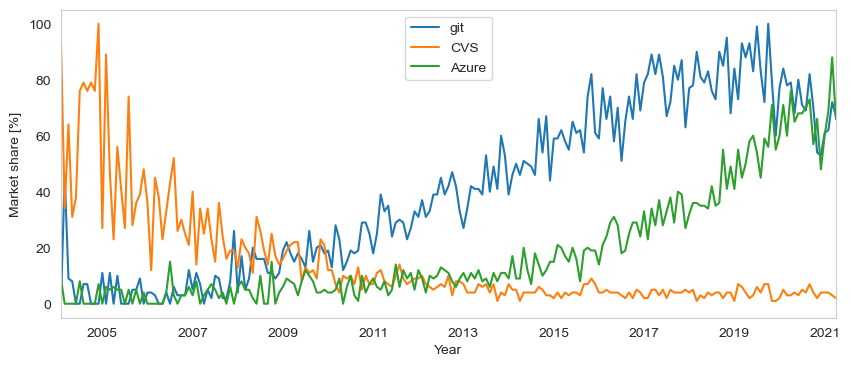

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
repodf = pd.read_csv('data/repository_popularity.csv',parse_dates=['Date'],index_col=['Date'])
repodf.plot(ax=ax);
ax.set_xlabel('Year');
ax.set_ylabel('Market share [%]');

### Git servers
There are many servers available. These services include 
- Repository
- Issue tracking 
- Project management (Kanban tables etc.)

__Public__
- [GitHub](https://www.github.com)
- [GitLab](https://www.gitlab.com)
- [BitBucket](https://bitbucket.org/)

__Local__
- [ETH GitLab](https://gitlab.ethz.ch)
- [PSI Gitea](https://gitea.psi.ch)



## Repository workflows
- Single branch (like a backup server with comments)
- Multiple branches (Recommended)
<img src='figures/RepositoryNetwork.png' style="height:400px"/>


<div class="alert alert-success">
<center>Never commit to main branch unless the code is tested and reviewed.</center>
</div>

The recommended workflow when you work with a repository is to generously work with branches for each new sub task of the development. This make it easier to maintain a stable main branch that other people in the team can rely on to perform the tasks correctly and without crashing. The work in the branches are merged into the main after synchronization and review with a team mate.

```{figure} figures/RepositoryNetwork.png
---
scale: 100%
---
A snapshot of the branch network from a git repository.
```

[GitHub tutorials](https://guides.github.com)

## Continuous Integration
Conntinuous integration is the process of running tests automatically everytime changes are made. 

This is possible to setup inside of many IDEs and is offered as a commercial service from companies like CircleCI and Travis. 


Projects like scikit-image use them to ensure changes that are made do not break existing code without requiring manual checks

<img src="figures/TravisCI.png" style="height:400px">

```{figure} figures/TravisCI.png
---
scale: 80%
---
Test reporting in Travis.
```

## A git demonstration

Using GitHub we will
- Create a repository
- Add some files and commit
- Push and pull
- Create and switch to new branch
- Make changes
- Merge branch into main 

# Summary

## Multiple modalities
- Add more information to improve the conclusions
- Add component in the analysis and visualization
- Data fusion can be done on different levels of abstraction.

## Software engineering
- Documentation
- Unit testing
- Working with repositories
- Contiuous integration